Import required packages


In [ ]:
import pandas as pd
import os
import datetime

In [ ]:
def get_query(table_name: str, start_date: str, end_date: str) -> str:
    return f"""
        SELECT 
         event_date,
         event_timestamp, 
         event_name, 
         event_parameters.key AS event_param_key, 
         event_parameters.value.int_value AS event_param_int, 
         event_parameters.value.string_value AS event_param_string,
         user_pseudo_id, 
         user_prop.key AS user_prop_key, 
         user_prop.value.string_value AS user_prop_string
        FROM
         `{table_name}` as T,
          UNNEST(user_properties) AS user_prop,
          UNNEST(event_params) AS event_parameters
        WHERE 
          _TABLE_SUFFIX BETWEEN "{start_date}" AND "{end_date}"
          AND ((event_name = "user_engagement" AND event_parameters.key = "engagement_time_msec") OR (event_name = "notification_receive") OR event_name = "notification_open")
          AND (user_prop.key = "subjectId" OR user_prop.key = "projectId")
    """

In [ ]:

def get_list_of_studies(query_result: pd.DataFrame):
    return query_result[query_result['user_prop_key'] == 'projectId'][['user_pseudo_id', 'user_prop_string']]


def write_to_csv_file(filename: str, filepath: str, data: pd.DataFrame):
    os.makedirs(filepath, exist_ok=True)
    with open(os.path.join(filepath, filename), 'w') as f:
        f.write(data.to_csv(index_label='index'))
    print('Written to File successfully.')


In [ ]:
def format_datetime(obj: datetime) -> str:
    return obj.strftime('%Y%m%d')

In [ ]:
from google.cloud import bigquery

# Only run once, if data is saved please proceed to next step.

# Construct a BigQuery client object.
client = bigquery.Client.from_service_account_json('radar-armt-notification-c2040a9b15cb.json')

table = 'radar-armt-notification.analytics_180955751.events_*'
start = format_datetime(datetime.datetime.now() - datetime.timedelta(days=200))
end = format_datetime(datetime.datetime.now())

result = client.query(get_query(table, start, end))  # Make an API request.
result_df: pd.DataFrame = result.to_dataframe()

# Save dataframe to file so we don't need to query bigqeury again and again.
write_to_csv_file('data.csv', 'data/' + f'{start}' + f'-{end}', data=result_df)

In [ ]:
# load data saved in csv file

file = 'data/20190927-20200414/data.csv'

result_df = pd.read_csv(file)

In [ ]:
result_df.head()

In [ ]:
def pre_process(data: pd.DataFrame) -> pd.DataFrame:
    data.index = pd.to_datetime(data['event_timestamp'] * 1000)
    print('Created date time index')
    project_ids = data[data['user_prop_key'] == 'projectId']['user_prop_string']
    print('got project Ids')
    data = data[data['user_prop_key'] != 'projectId']
    print('removed rows with project id as they are duplicates')
    data = data.drop(axis=1, columns=['user_prop_key'])
    print('dropped user prop keys')
    data.loc[:,'engagement_time_msec'] = data['event_param_int']
    print('created column of engagement time msec')
    data.rename({'user_prop_string': 'subjectId'}, axis=1, inplace=True)
    print('renamed user prop string to subjectId')
    data.loc[:,'message_type'] = data['event_param_string']
    print('created column. message type')
    data = data.drop(axis=1, columns = ['event_param_int', 'event_param_string', 'event_param_key'])
    print('dropped unnecessary columns')
    data = pd.concat([data, project_ids.dropna()], axis=1)
    print('added column for project Ids')
    data.rename({'user_prop_string': 'projectId'}, axis=1, inplace=True)
    print('renamed user prop string to projectId')
    return data

In [ ]:
# If possible load this from file as it take a long time to pre process the data due to its volume.

processed_df = pre_process(result_df)
write_to_csv_file('processed-data.csv', 'data/20190927-20200414', data=processed_df)

In [ ]:
processed_df = pd.read_csv('data/20190927-20200414/processed-data.csv', parse_dates=True, date_parser=pd.to_datetime, index_col='index')

In [ ]:
processed_df.head()

In [ ]:
start_date = pd.to_datetime('2019-11-12')
end_date = pd.to_datetime('2020-04-11')

processed_df_2 = processed_df.loc[(processed_df.index > start_date) & (processed_df.index < end_date)]

In [ ]:
resampled = processed_df_2[processed_df_2['event_name'] == 'user_engagement'].resample('20D')

In [ ]:
import matplotlib.pyplot as plt

#.drop(labels=pd.to_datetime('2020-03-26'), axis='index')
resampled['engagement_time_msec'].sum().plot(figsize=(15,4))
plt.title('Total User Engagement Time')

plt.xlabel('Time')
plt.ylabel('Total Engagement Time (msec)')

plt.xticks(['2019-12-15', '2020-01-01', '2020-01-15', '2020-02-01', '2020-02-15', '2020-03-01', '2020-03-15' ])

In [ ]:
# Calculate user engagement per user

user_eng_df = processed_df_2[processed_df_2['event_name'] == 'user_engagement']
grouped_df = user_eng_df.groupby([pd.Grouper(freq='19D')])

In [ ]:
for name, group in grouped_df:
    print(name)

In [ ]:
# Aggregate enagement time as sum and count the number of unique users
grouped_df_agg = grouped_df.agg(engagement_time_sum_min=pd.NamedAgg(column='engagement_time_msec', aggfunc=lambda x: x.sum()/ 1000 / 60),
                                user_pseudo_id_count=pd.NamedAgg(column='user_pseudo_id', aggfunc= lambda x: x.nunique()))

In [ ]:
grouped_df_agg.head()

In [ ]:
grouped_df_agg['engagement_per_user'] = grouped_df_agg['engagement_time_sum_min']/grouped_df_agg['user_pseudo_id_count']

In [ ]:
grouped_df_agg.tail()

In [ ]:
grouped_df_agg.index = grouped_df_agg.index + datetime.timedelta(days=19)

In [ ]:

#grouped_df_agg.loc[pd.to_datetime('2020-03-25'), :] = grouped_df_agg.loc[pd.to_datetime('2020-03-06'), :]
grouped_df_agg['engagement_per_user'].plot(figsize=(15, 4))

plt.title('User Engagement Time/User')

plt.xlabel('Time')
plt.ylabel('Engagement Time/User (minutes)')

plt.xticks([
            '2019-11-15', '2019-12-01',
            '2019-12-15', '2020-01-01',
            '2020-01-15', '2020-02-01',
            '2020-02-15', '2020-03-01',
            '2020-03-15', '2020-04-01', '2020-04-15' ])

In [ ]:
notifs_df = processed_df_2[(processed_df_2['event_name'] == 'notification_open') & (processed_df_2['message_type'] == 'fcm')]

In [ ]:
resampled_notifs = notifs_df.groupby([pd.Grouper(freq='19D')])

In [ ]:
resampled_notifs

In [ ]:
resampled_notifs_agg = resampled_notifs.agg(notif_open_count=pd.NamedAgg(column='event_name', aggfunc='count'),
                     user_pseudo_id_count=pd.NamedAgg(column='user_pseudo_id', aggfunc=lambda x: x.nunique()))

In [ ]:
resampled_notifs_agg['notif_open_per_user'] = resampled_notifs_agg['notif_open_count'] / resampled_notifs_agg['user_pseudo_id_count']

In [ ]:
resampled_notifs_agg.head()

In [ ]:
resampled_notifs_agg.index = resampled_notifs_agg.index + datetime.timedelta(days=19)

In [ ]:
resampled_notifs_agg['notif_open_per_user'].plot(figsize=(15, 4))


plt.title('Number of opened Notifications / User')

plt.xlabel('Time')
plt.ylabel('Number of opened Notifications / User')

plt.xticks([
            '2019-11-15', '2019-12-01',
            '2019-12-15', '2020-01-01',
            '2020-01-15', '2020-02-01',
            '2020-02-15', '2020-03-01',
            '2020-03-15', '2020-04-01', '2020-04-15' ])

In [ ]:
notifs_received_df = processed_df_2[(processed_df_2['event_name'] == 'notification_receive') &
                                    (processed_df_2['message_type'] == 'display')]

In [ ]:
resampled_notifs_received_df = notifs_received_df.groupby([pd.Grouper(freq='19D')])

In [ ]:
resampled_notifs_received_df_agg = resampled_notifs_received_df.agg(notif_receive_count=pd.NamedAgg(column='event_name', aggfunc='count'),
                     user_pseudo_id_count=pd.NamedAgg(column='user_pseudo_id', aggfunc=lambda x: x.nunique()))

In [ ]:
resampled_notifs_received_df_agg['notif_received_per_user'] = resampled_notifs_received_df_agg['notif_receive_count'] / resampled_notifs_received_df_agg['user_pseudo_id_count']

In [ ]:
resampled_notifs_received_df_agg.head()

In [ ]:
resampled_notifs_received_df_agg.index = resampled_notifs_received_df_agg.index + datetime.timedelta(days=19)

In [ ]:
resampled_notifs_received_df_agg['notif_received_per_user'].plot(figsize=(15, 4))


plt.title('Number of Received Notifications / User')

plt.xlabel('Time')
plt.ylabel('Number of Received Notifications / User')

plt.xticks(['2019-11-01',
            '2019-11-15', '2019-12-01',
            '2019-12-15', '2020-01-01',
            '2020-01-15', '2020-02-01',
            '2020-02-15', '2020-03-01',
            '2020-03-15', '2020-04-01' ])

In [ ]:
resampled_notifs_received_df_agg['percent_open'] = resampled_notifs_agg['notif_open_count'] / resampled_notifs_received_df_agg['notif_receive_count']

In [ ]:
resampled_notifs_received_df_agg.tail()

In [ ]:
resampled_notifs_received_df_agg.index = resampled_notifs_received_df_agg.index + datetime.timedelta(days=19)

In [ ]:
resampled_notifs_received_df_agg['percent_open'].plot(figsize=(15, 4))


plt.title('Percent of opened notifications vs received')

plt.xlabel('Time')
plt.ylabel('Percent of opened notifications vs received')

plt.xticks(['2019-11-15', '2019-12-01',
            '2019-12-15', '2020-01-01',
            '2020-01-15', '2020-02-01',
            '2020-02-15', '2020-03-01',
            '2020-03-15', '2020-04-01',
            '2020-04-15'])
plt.show()

In [313]:
# Calculate user engagement per user per project

user_eng_project_df = processed_df_2[processed_df_2['event_name'] == 'user_engagement']
project_grouped_df = user_eng_project_df.groupby(['projectId', pd.Grouper(freq='19D')])

In [314]:
# Aggregate enagement time as sum and count the number of unique users
project_grouped_df_agg = project_grouped_df.agg(engagement_time_sum_min=pd.NamedAgg(column='engagement_time_msec', aggfunc=lambda x: x.sum()/ 1000 / 60),
                                user_pseudo_id_count=pd.NamedAgg(column='user_pseudo_id', aggfunc= lambda x: x.nunique()))

In [315]:
project_grouped_df_agg['engagement_per_user'] = project_grouped_df_agg['engagement_time_sum_min']/project_grouped_df_agg['user_pseudo_id_count']

In [316]:
project_grouped_df_agg.head()

engagement_time_sum_min  user_pseudo_id_count  \
projectId event_timestamp                                                  
DynaMINT  2020-03-05                     31.039117                     1   
          2020-03-24                     28.534617                     1   
DynaMOBS  2020-03-05                     11.218567                     1   
DynaMORE  2020-01-08                    117.758183                     7   
          2020-01-27                     92.724633                     8   

                           engagement_per_user  
projectId event_timestamp                       
DynaMINT  2020-03-05                 31.039117  
          2020-03-24                 28.534617  
DynaMOBS  2020-03-05                 11.218567  
DynaMORE  2020-01-08                 16.822598  
          2020-01-27                 11.590579

In [ ]:
for (name, timerange), group in project_grouped_df:
    print(name)

In [318]:
LONDON_UK = ['RADAR-MDD-KCL-s1']
BARCELONA_SPAIN = ['RADAR-MDD-CIBER-s1', 'RADAR-MSDis-VHIR-s1', 'RADAR-MSDep-VHIR-s1', 'RADAR-MDD-IISPV-s1']
COPENHAGEN_DENMARK = ['RADAR-MSDep-RegionH-s1', 'RADAR-MSDis-RegionH-s1']
MILAN_ITALY = ['RADAR-MSDep-OSR-s1', 'RADAR-MSDis-OSR-s1']
AMSTERDAM_NETHERLANDS = ['RADAR-MDD-VUmc-s1']
ALL_RADAR_CNS = LONDON_UK + BARCELONA_SPAIN + COPENHAGEN_DENMARK + MILAN_ITALY + AMSTERDAM_NETHERLANDS

In [319]:
print(ALL_RADAR_CNS)

['RADAR-MDD-KCL-s1', 'RADAR-MDD-CIBER-s1', 'RADAR-MSDis-VHIR-s1', 'RADAR-MSDep-VHIR-s1', 'RADAR-MDD-IISPV-s1', 'RADAR-MSDep-RegionH-s1', 'RADAR-MSDis-RegionH-s1', 'RADAR-MSDep-OSR-s1', 'RADAR-MSDis-OSR-s1', 'RADAR-MDD-VUmc-s1']


In [327]:
# Drop all columns not part of RADAR-CNS

projects_to_discard = [project for project in project_grouped_df_agg.index.get_level_values('projectId') if project not in ALL_RADAR_CNS ]
print(projects_to_discard)
project_grouped_df_agg = project_grouped_df_agg.drop(labels=projects_to_discard, axis=0, level='projectId')

['DynaMINT', 'DynaMINT', 'DynaMOBS', 'DynaMORE', 'DynaMORE', 'DynaMORE', 'DynaMORE', 'DynaMORE', 'ESMBruno-EPI-KCL-s1', 'Epilepsy-ESM-Study_aRMT', 'Epilepsy-ESM-Study_aRMT', 'MS_TEST', 'MS_TEST', 'MS_TEST', 'MS_TEST', 'MS_TEST', 'MS_TEST', 'MS_TEST', 'RADAR-ART-KCL-s1', 'RADAR-ART-KCL-s1', 'RADAR-ART-KCL-s1', 'RADAR-ART-KCL-s1', 'RADAR-ART-KCL-s1', 'RADAR-ART-KCL-s1', 'RADAR-RAPID-KCL-s1', 'RADAR-RAPID-KCL-s1', 'STAGING_PROJECT', 'STAGING_PROJECT', 'STAGING_PROJECT', 'STAGING_PROJECT', 'STAGING_PROJECT', 'STAGING_PROJECT', 'STAGING_PROJECT', 'STAGING_PROJECT', 'radarbase-fivoor', 'radarbase-tfs-cro']


In [406]:
project_grouped_df_agg.head()

engagement_time_sum_min  \
projectId          event_timestamp                            
RADAR-MDD-CIBER-s1 2019-11-12                    501.741533   
                   2019-12-01                    646.552217   
                   2019-12-20                   1006.753583   
                   2020-01-08                    822.244367   
                   2020-01-27                   1190.353000   

                                    user_pseudo_id_count  engagement_per_user  
projectId          event_timestamp                                             
RADAR-MDD-CIBER-s1 2019-11-12                         84             5.973113  
                   2019-12-01                         85             7.606497  
                   2019-12-20                         81            12.429057  
                   2020-01-08                         83             9.906559  
                   2020-01-27                         82            14.516500

In [448]:
# Calculate notifications opened per user per project

user_notif_project_df = processed_df_2[(processed_df_2['event_name'] == 'notification_open') & (processed_df_2['message_type'] == 'fcm')]
project_grouped_notif_df = user_notif_project_df.groupby(['projectId', pd.Grouper(freq='19D')])

In [449]:
# Aggregate notif as count and count the number of unique users
project_grouped_notif_df_agg = project_grouped_notif_df.agg(notif_open_count=pd.NamedAgg(column='event_name', aggfunc='count'),
                                user_pseudo_id_count=pd.NamedAgg(column='user_pseudo_id', aggfunc= lambda x: x.nunique()))

In [450]:
project_grouped_notif_df_agg['notif_open_per_user'] = project_grouped_notif_df_agg['notif_open_count'] / project_grouped_notif_df_agg['user_pseudo_id_count']

In [451]:
project_grouped_notif_df_agg = project_grouped_notif_df_agg.drop(labels=projects_to_discard, axis=0, level='projectId')

In [452]:
project_grouped_notif_df_agg.head()

notif_open_count  user_pseudo_id_count  \
projectId          event_timestamp                                           
RADAR-MDD-CIBER-s1 2019-11-12                    108                    51   
                   2019-12-01                     98                    44   
                   2019-12-20                    114                    52   
                   2020-01-08                     93                    48   
                   2020-01-27                    104                    52   

                                    notif_open_per_user  
projectId          event_timestamp                       
RADAR-MDD-CIBER-s1 2019-11-12                  2.117647  
                   2019-12-01                  2.227273  
                   2019-12-20                  2.192308  
                   2020-01-08                  1.937500  
                   2020-01-27                  2.000000

In [453]:
notifs_received_df = processed_df_2[(processed_df_2['event_name'] == 'notification_receive') &
                                    (processed_df_2['message_type'] == 'display')]
project_grouped_notifs_received_df = notifs_received_df.groupby(['projectId', pd.Grouper(freq='19D')])

In [454]:
# Aggregate notif as count and count the number of unique users
project_grouped_notifs_received_df_agg = project_grouped_notifs_received_df.agg(notif_receive_count=pd.NamedAgg(column='event_name', aggfunc='count'),
                                user_pseudo_id_count=pd.NamedAgg(column='user_pseudo_id', aggfunc= lambda x: x.nunique()))

In [455]:
project_grouped_notifs_received_df_agg = project_grouped_notifs_received_df_agg.drop(labels=projects_to_discard, axis=0, level='projectId')

In [456]:
project_grouped_notif_df_agg['percent_open'] = project_grouped_notif_df_agg['notif_open_count'] / project_grouped_notifs_received_df_agg['notif_receive_count']

In [457]:
project_grouped_notif_df_agg.head()

notif_open_count  user_pseudo_id_count  \
projectId          event_timestamp                                           
RADAR-MDD-CIBER-s1 2019-11-12                    108                    51   
                   2019-12-01                     98                    44   
                   2019-12-20                    114                    52   
                   2020-01-08                     93                    48   
                   2020-01-27                    104                    52   

                                    notif_open_per_user  percent_open  
projectId          event_timestamp                                     
RADAR-MDD-CIBER-s1 2019-11-12                  2.117647      0.400000  
                   2019-12-01                  2.227273      0.382812  
                   2019-12-20                  2.192308      0.402827  
                   2020-01-08                  1.937500      0.336957  
                   2020-01-27                  2.000000      0.304985

In [458]:
project_grouped_notifs_received_df_agg.head()

notif_receive_count  user_pseudo_id_count
projectId          event_timestamp                                           
RADAR-MDD-CIBER-s1 2019-11-12                       270                    86
                   2019-12-01                       256                    87
                   2019-12-20                       283                    90
                   2020-01-08                       276                    93
                   2020-01-27                       341                    92

In [401]:
def get_data_for_study(grouped_data: pd.DataFrame,
                       study_names: list,
                       aggregations: dict,
                       days_to_add = 19):
    data = grouped_data.loc[study_names, :]
    data = data.reset_index(level='projectId')
    data_agg = data.groupby('event_timestamp').agg(aggregations)
    data_agg.index = data_agg.index + datetime.timedelta(days=days_to_add)
    return data_agg
    
def plot_for_study(data:pd.DataFrame,
                   column_name: str,
                   title: str,
                   ylabel: str,
                   lockdown_rec: str,
                   lockdown: str,
                   xlabel='Time',
                   figsize=(15, 4),
                   ylim_min = 6,
                   ylim_max = 23):
    data[column_name].plot(figsize=(15, 4))

    plt.title(title)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.xticks(['2019-11-15', '2019-12-01',
                '2019-12-15', '2020-01-01',
                '2020-01-15', '2020-02-01',
                '2020-02-15', '2020-03-01',
                '2020-03-15', '2020-04-01',
                '2020-04-15'])
    plt.vlines([lockdown_rec], ylim_min, ylim_max, linestyles='dashed', colors='g', label='National Recommendation')
    plt.vlines([lockdown], ylim_min, ylim_max, linestyles='dashed', colors='r', label='National Lockdown')
    plt.show()
    

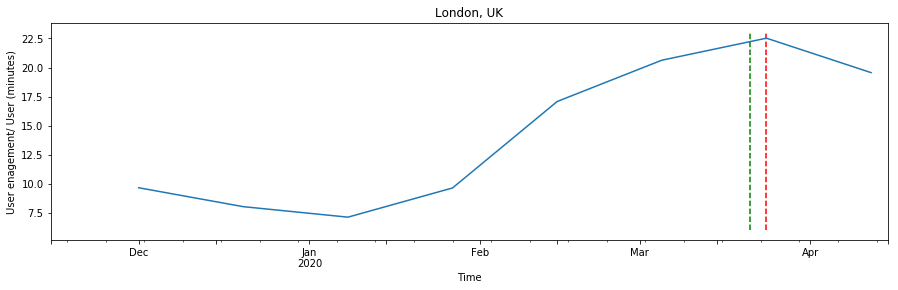

In [460]:
# UK User engagement plot
london_data = get_data_for_study(project_grouped_df_agg,
                                    LONDON_UK,
                                    {'engagement_time_sum_min' : 'sum', 'user_pseudo_id_count': 'sum'})
london_data['engagement_per_user'] = london_data['engagement_time_sum_min'] / london_data['user_pseudo_id_count']

plot_for_study(london_data,
               'engagement_per_user',
               'London, UK',
               'User enagement/ User (minutes)',
               '2020-03-21',
               '2020-03-24',
               ylim_min = 6,
               ylim_max = 23)

In [ ]:
def aggregate_percent_open(x):
    

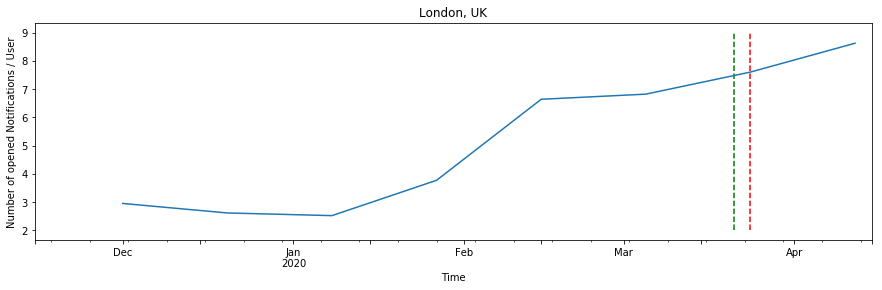

In [463]:
# UK number of opened notifications per user plot
london_notif_data = get_data_for_study(project_grouped_notif_df_agg,
                                    LONDON_UK,
                                    {'notif_open_count' : 'sum', 'user_pseudo_id_count': 'sum'})
london_notif_received_data = get_data_for_study(project_grouped_notifs_received_df_agg,
                                    LONDON_UK,
                                    {'notif_receive_count' : 'sum', 'user_pseudo_id_count': 'sum'})
london_notif_data['notif_open_per_user'] = london_notif_data['notif_open_count'] / london_notif_data['user_pseudo_id_count']
london_notif_data['percent_open'] = london_notif_data['notif_open_count'] / london_notif_received_data['notif_receive_count']
plot_for_study(london_notif_data,
               'notif_open_per_user',
               'London, UK',
               'Number of opened Notifications / User',
               '2020-03-21',
               '2020-03-24',
               ylim_min = 2,
               ylim_max = 9)

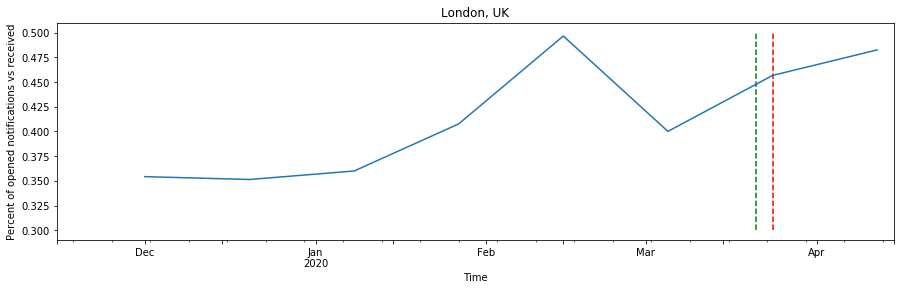

In [474]:
# UK percent of opened notifications vs received plot

plot_for_study(london_notif_data,
               'percent_open',
               'London, UK',
               'Percent of opened notifications vs received',
               '2020-03-21',
               '2020-03-24',
               ylim_min = 0.3,
               ylim_max = 0.5)

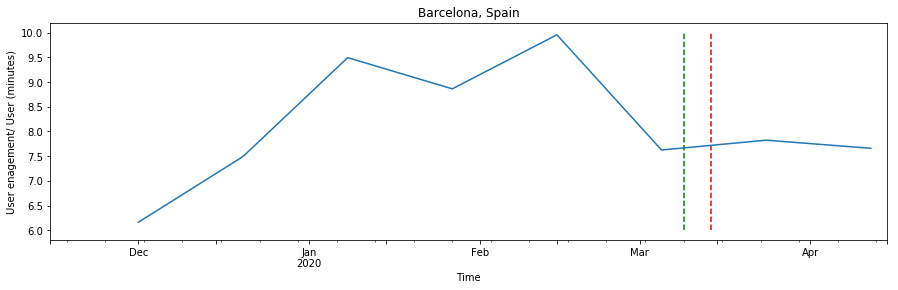

In [404]:
# Spain User engagement plot
barcelona_data = get_data_for_study(project_grouped_df_agg,
                                    BARCELONA_SPAIN,
                                    {'engagement_time_sum_min' : 'sum', 'user_pseudo_id_count': 'sum'})
barcelona_data['engagement_per_user'] = barcelona_data['engagement_time_sum_min'] / barcelona_data['user_pseudo_id_count']

plot_for_study(barcelona_data,
               'engagement_per_user',
               'Barcelona, Spain',
               'User enagement/ User (minutes)',
               '2020-03-09',
               '2020-03-14',
               ylim_min = 6,
               ylim_max = 10)

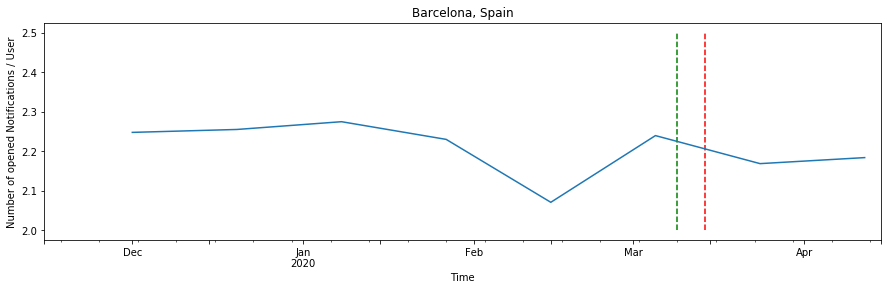

In [467]:
# Spain number of opened notifications per user plot

barcelona_notif_data = get_data_for_study(project_grouped_notif_df_agg,
                                    BARCELONA_SPAIN,
                                    {'notif_open_count' : 'sum', 'user_pseudo_id_count': 'sum'})
barcelona_notif_received_data = get_data_for_study(project_grouped_notifs_received_df_agg,
                                    BARCELONA_SPAIN,
                                    {'notif_receive_count' : 'sum', 'user_pseudo_id_count': 'sum'})
barcelona_notif_data['notif_open_per_user'] = barcelona_notif_data['notif_open_count'] / barcelona_notif_data['user_pseudo_id_count']
barcelona_notif_data['percent_open'] = barcelona_notif_data['notif_open_count'] / barcelona_notif_received_data['notif_receive_count']
plot_for_study(barcelona_notif_data,
               'notif_open_per_user',
               'Barcelona, Spain',
               'Number of opened Notifications / User',
               '2020-03-09',
               '2020-03-14',
               ylim_min = 2,
               ylim_max = 2.5)


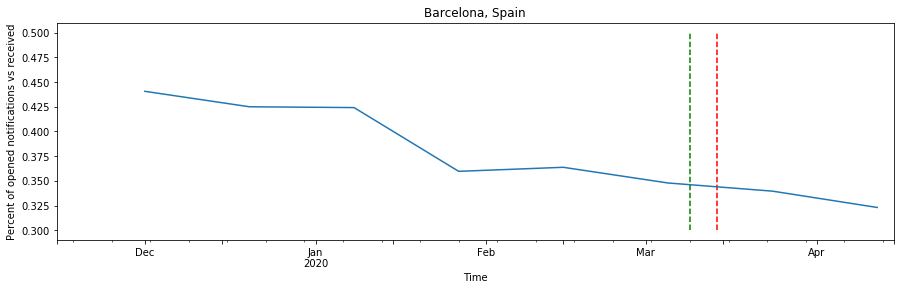

In [476]:
# Spain percent of opened notifications vs received plot
plot_for_study(barcelona_notif_data,
               'percent_open',
               'Barcelona, Spain',
               'Percent of opened notifications vs received',
               '2020-03-09',
               '2020-03-14',
               ylim_min = 0.3,
               ylim_max = 0.5)

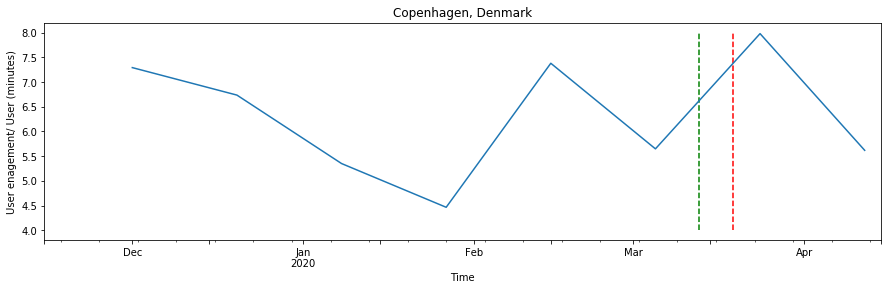

In [424]:
# Denmark User engagement plot
copenhagen_data = get_data_for_study(project_grouped_df_agg,
                                    COPENHAGEN_DENMARK,
                                    {'engagement_time_sum_min' : 'sum', 'user_pseudo_id_count': 'sum'})
copenhagen_data['engagement_per_user'] = copenhagen_data['engagement_time_sum_min'] / copenhagen_data['user_pseudo_id_count']

plot_for_study(copenhagen_data,
               'engagement_per_user',
               'Copenhagen, Denmark',
               'User enagement/ User (minutes)',
               '2020-03-13',
               '2020-03-19',
               ylim_min = 4,
               ylim_max = 8)

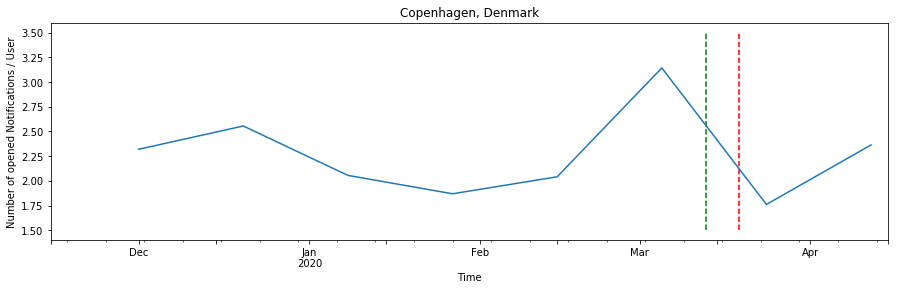

In [470]:
# Denmark number of opened notifications per user plot
copenhagen_notif_data = get_data_for_study(project_grouped_notif_df_agg,
                                    COPENHAGEN_DENMARK,
                                    {'notif_open_count' : 'sum', 'user_pseudo_id_count': 'sum'})
copenhagen_notif_received_data = get_data_for_study(project_grouped_notifs_received_df_agg,
                                    COPENHAGEN_DENMARK,
                                    {'notif_receive_count' : 'sum', 'user_pseudo_id_count': 'sum'})
copenhagen_notif_data['notif_open_per_user'] = copenhagen_notif_data['notif_open_count'] / copenhagen_notif_data['user_pseudo_id_count']
copenhagen_notif_data['percent_open'] = copenhagen_notif_data['notif_open_count'] / copenhagen_notif_received_data['notif_receive_count']
plot_for_study(copenhagen_notif_data,
               'notif_open_per_user',
               'Copenhagen, Denmark',
               'Number of opened Notifications / User',
               '2020-03-13',
               '2020-03-19',
               ylim_min = 1.5,
               ylim_max = 3.5)

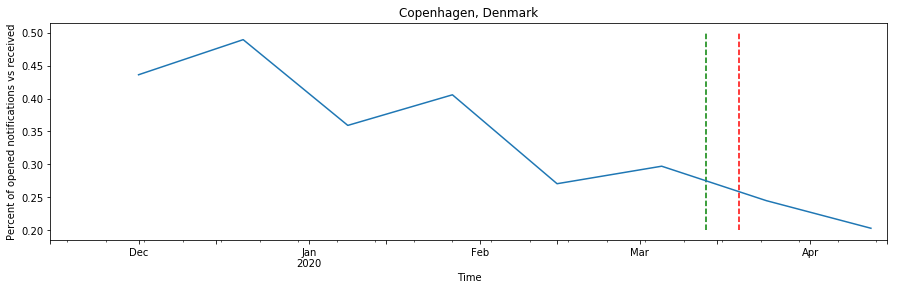

In [478]:
# Denmark percent of opened notifications vs received plot
plot_for_study(copenhagen_notif_data,
               'percent_open',
               'Copenhagen, Denmark',
               'Percent of opened notifications vs received',
               '2020-03-13',
               '2020-03-19',
               ylim_min = 0.2,
               ylim_max = 0.5)

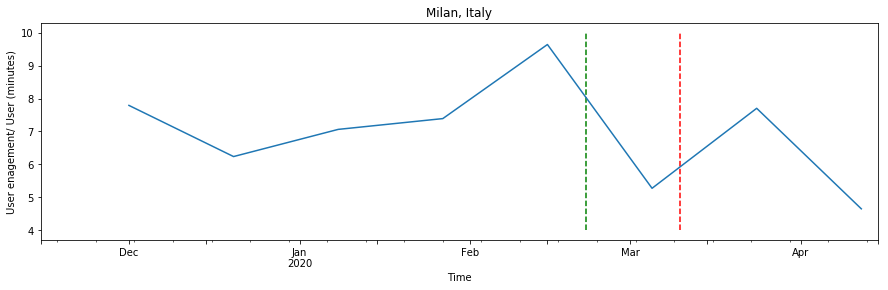

In [426]:
# Italy User engagement plot
milan_data = get_data_for_study(project_grouped_df_agg,
                                    MILAN_ITALY,
                                    {'engagement_time_sum_min' : 'sum', 'user_pseudo_id_count': 'sum'})
milan_data['engagement_per_user'] = milan_data['engagement_time_sum_min'] / milan_data['user_pseudo_id_count']

plot_for_study(milan_data,
               'engagement_per_user',
               'Milan, Italy',
               'User enagement/ User (minutes)',
               '2020-02-22',
               '2020-03-10',
               ylim_min = 4,
               ylim_max = 10)

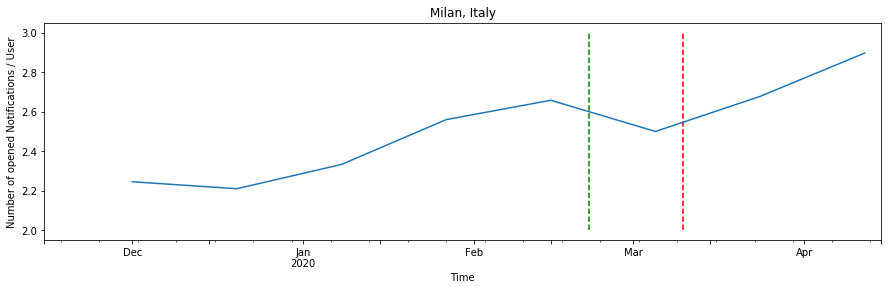

In [472]:
# Italy number of opened notifications per user plot
milan_notif_data = get_data_for_study(project_grouped_notif_df_agg,
                                    MILAN_ITALY,
                                    {'notif_open_count' : 'sum', 'user_pseudo_id_count': 'sum'})
milan_notif_received_data = get_data_for_study(project_grouped_notifs_received_df_agg,
                                    MILAN_ITALY,
                                    {'notif_receive_count' : 'sum', 'user_pseudo_id_count': 'sum'})
milan_notif_data['notif_open_per_user'] = milan_notif_data['notif_open_count'] / milan_notif_data['user_pseudo_id_count']
milan_notif_data['percent_open'] = milan_notif_data['notif_open_count'] / milan_notif_received_data['notif_receive_count']
plot_for_study(milan_notif_data,
               'notif_open_per_user',
               'Milan, Italy',
               'Number of opened Notifications / User',
               '2020-02-22',
               '2020-03-10',
               ylim_min = 2,
               ylim_max = 3)

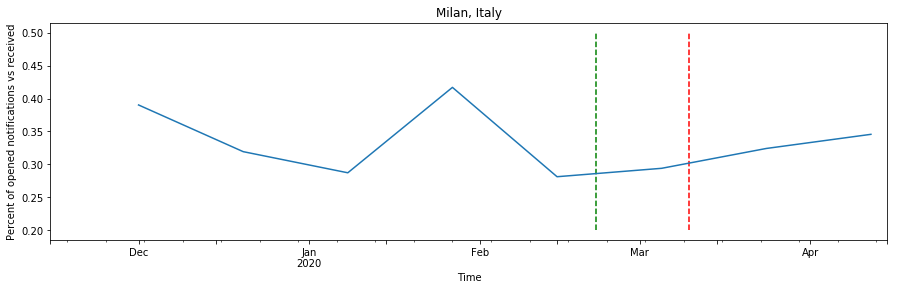

In [479]:
# Italy percent of opened notifications vs received plot

plot_for_study(milan_notif_data,
               'percent_open',
               'Milan, Italy',
               'Percent of opened notifications vs received',
               '2020-02-22',
               '2020-03-10',
               ylim_min = 0.2,
               ylim_max = 0.5)